In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
 
from sklearn.model_selection import train_test_split
from sklearn import metrics
 
import cv2
import gc
import os
 
import tensorflow as tf
from tensorflow import keras
from keras import layers
 
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = '/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets'
classes = os.listdir(path)
classes

['lung_aca', 'lung_scc', 'lung_n']

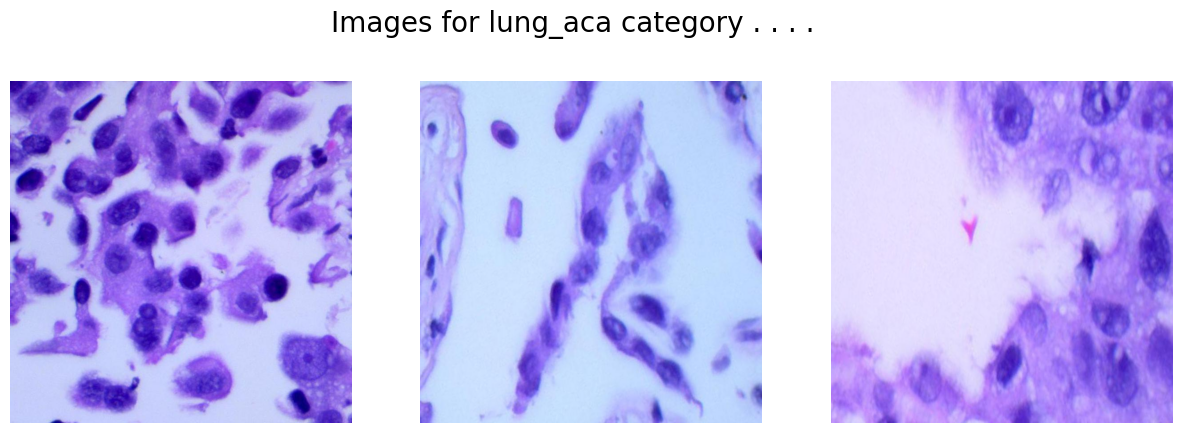

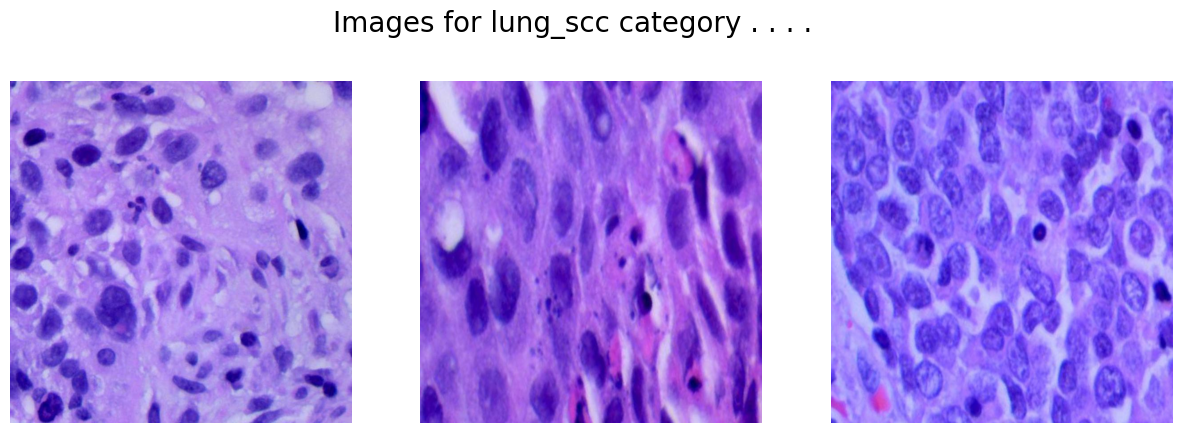

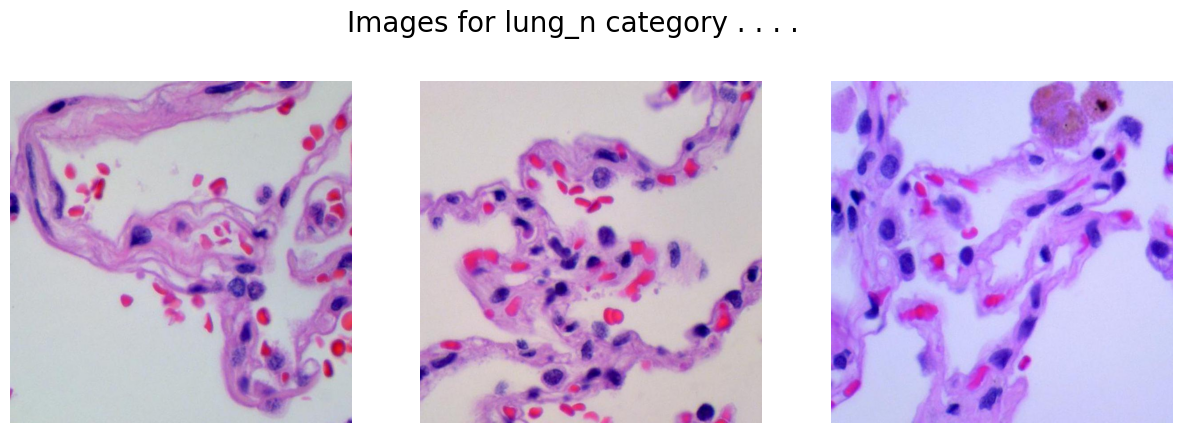

In [3]:
for cat in classes:
    image_dir = f'{path}/{cat}'
    images = os.listdir(image_dir)
 
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    fig.suptitle(f'Images for {cat} category . . . .', fontsize=20)
 
    for i in range(3):
        k = np.random.randint(0, len(images))
        img = np.array(Image.open(f'{path}/{cat}/{images[k]}'))
        ax[i].imshow(img)
        ax[i].axis('off')
    plt.show()

In [4]:
IMG_SIZE = 256
SPLIT = 0.2
EPOCHS = 10
BATCH_SIZE = 64

In [5]:
X = []
Y = []
 
for i, cat in enumerate(classes):
  images = glob(f'{path}/{cat}/*.jpeg')
 
  for image in images:
    img = cv2.imread(image)
     
    X.append(cv2.resize(img, (IMG_SIZE, IMG_SIZE)))
    Y.append(i)
 
X = np.asarray(X)
one_hot_encoded_Y = pd.get_dummies(Y).values

In [6]:
X_train, X_val, Y_train, Y_val = train_test_split(X, one_hot_encoded_Y, test_size = SPLIT, 
                                                  random_state = 2022)
print(X_train.shape, X_val.shape)

(12000, 256, 256, 3) (3000, 256, 256, 3)


In [7]:
model = keras.models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(5, 5), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3), padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(3, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 128)      0

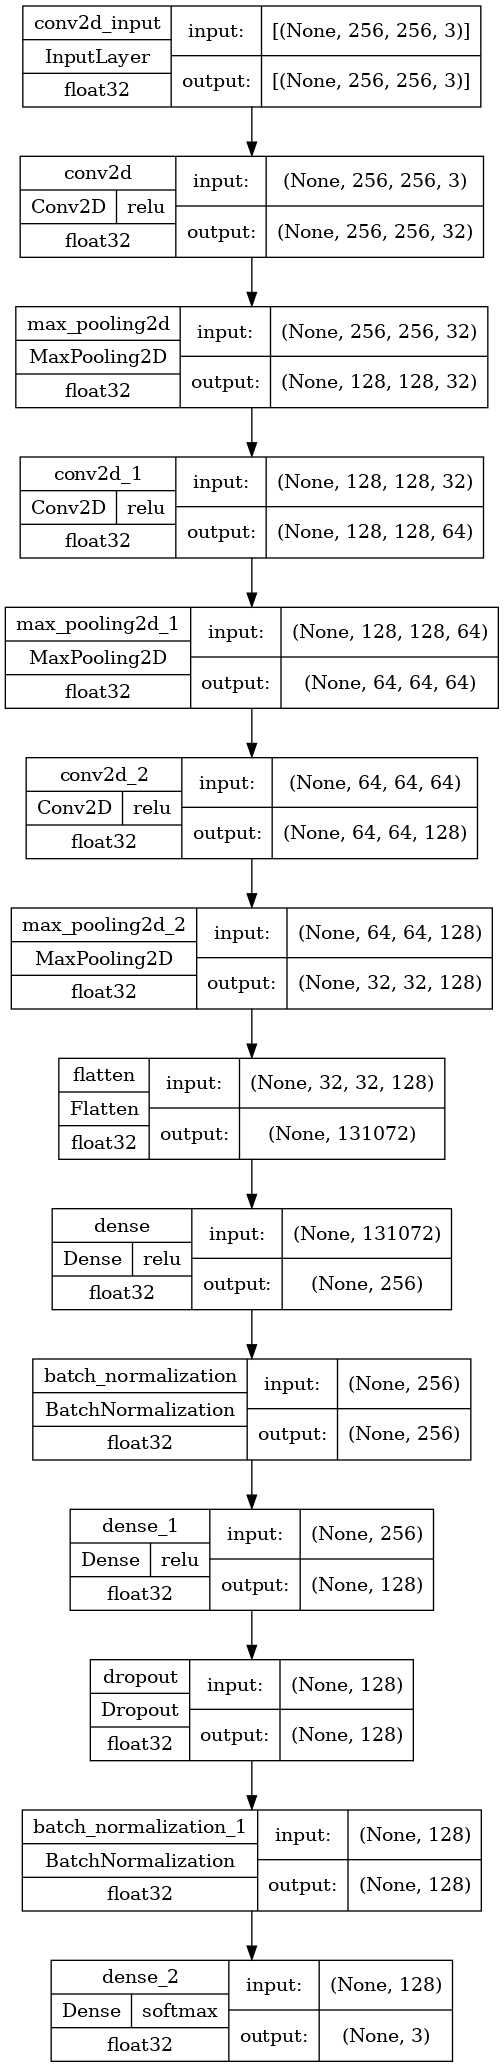

In [8]:
keras.utils.plot_model(model, show_shapes = True, show_dtype = True, show_layer_activations = True)

In [9]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [10]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('val_accuracy') > 0.90:
            print('\n Validation accuracy has reached upto \
                      90% so, stopping further training.')
            self.model.stop_training = True
es = EarlyStopping(patience=3, monitor='val_accuracy', restore_best_weights=True)
lr = ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.5, verbose=1)

In [11]:
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size = BATCH_SIZE, epochs = EPOCHS, verbose = 1, callbacks = [es, lr, myCallback()])

Epoch 1/10
188/188 [==============================] - 1303s 7s/step - loss: 0.3401 - accuracy: 0.8624 - val_loss: 0.7606 - val_accuracy: 0.7103 - lr: 0.0010
Epoch 2/10
188/188 [==============================] - 1248s 7s/step - loss: 0.2119 - accuracy: 0.9153 - val_loss: 3.1113 - val_accuracy: 0.6493 - lr: 0.0010
Epoch 3/10
188/188 [==============================] - ETA: 0s - loss: 0.1742 - accuracy: 0.9306
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
188/188 [==============================] - 1257s 7s/step - loss: 0.1742 - accuracy: 0.9306 - val_loss: 3.9555 - val_accuracy: 0.6710 - lr: 0.0010
Epoch 4/10
188/188 [==============================] - 1261s 7s/step - loss: 0.0995 - accuracy: 0.9632 - val_loss: 0.7746 - val_accuracy: 0.7637 - lr: 5.0000e-04
Epoch 5/10
188/188 [==============================] - ETA: 0s - loss: 0.0707 - accuracy: 0.9743
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
188/188 [==========================

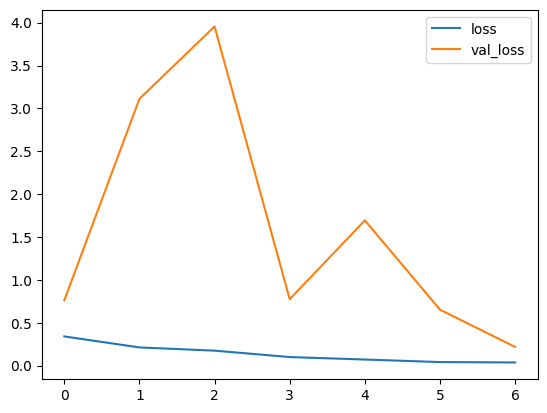

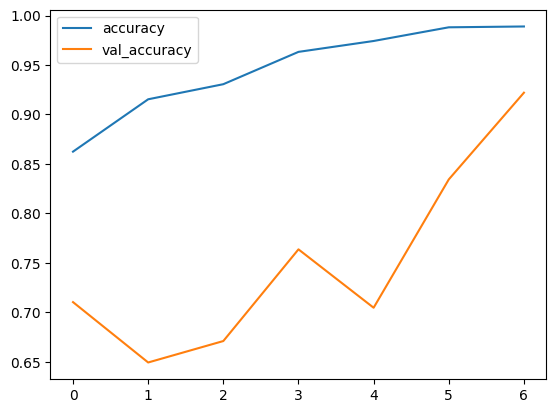

In [12]:
history_df = pd.DataFrame(history.history)
history_df.loc[:,['loss','val_loss']].plot()
history_df.loc[:,['accuracy','val_accuracy']].plot()
plt.show()

In [13]:
Y_pred = model.predict(X_val)
Y_val = np.argmax(Y_val, axis=1)
Y_pred = np.argmax(Y_pred, axis=1)

94/94 [==============================] - 82s 874ms/step


In [14]:
metrics.confusion_matrix(Y_val, Y_pred)

array([[ 938,   37,   12],
       [ 164,  813,    0],
       [  21,    0, 1015]])

In [15]:
print(metrics.classification_report(Y_val, Y_pred, target_names=classes))

              precision    recall  f1-score   support

    lung_aca       0.84      0.95      0.89       987
    lung_scc       0.96      0.83      0.89       977
      lung_n       0.99      0.98      0.98      1036

    accuracy                           0.92      3000
   macro avg       0.93      0.92      0.92      3000
weighted avg       0.93      0.92      0.92      3000

